In [103]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader
from lib.dataloader import OCTSegDataset
import torch
import numpy as np
import cv2
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import os
from matplotlib.colors import ListedColormap
from lib.models.model_zoo.t_net import tnet
from lib.models.model_zoo.ResNet50UNet import ResNet50UNet
from lib.models.UOCNet import UOCNet
from lib.models.UNET_OCT import UNET_OCT

# Function all in one place

# Segmentation Model

In [22]:
class SegPredictor:
    def __init__(self, checkpoint_path, num_classes=4, crop_size=512, device=None):
        # Choose device automatically if not specified
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_classes = num_classes
        self.crop_size = crop_size

        # Define preprocessing pipeline
        self.transform = transforms.Compose([
            transforms.Resize((crop_size, crop_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.08, 0.08, 0.08], std=[0.5, 0.5, 0.5])
            # transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
        ])

        # Initialize model
        self.model = self._initialize_model()
        self.model.to(self.device)

        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=self.device)
        self.model.load_state_dict(checkpoint["state_dict"])
        self.model.eval()

    def _initialize_model(self):
        """Initialize model."""
        model = models.segmentation.deeplabv3_resnet50(
            weights=models.segmentation.DeepLabV3_ResNet50_Weights.DEFAULT
        )
        model.classifier[4] = nn.Conv2d(256, self.num_classes, kernel_size=1)
        return model

    def _undo_padding(self, pred_img, original_size=(1400, 850), target_size=(512, 512)):
        "Removes padding and resizes prediction back to the original image size."
        th, tw = target_size
        oh, ow = original_size

        scale = min(tw / ow, th / oh)
        new_w, new_h = int(ow * scale), int(oh * scale)

        pad_w = (tw - new_w) // 2
        pad_h = (th - new_h) // 2

        cropped = pred_img[pad_h:pad_h+new_h, pad_w:pad_w+new_w]
        img_resized = cv2.resize(cropped, (ow, oh), interpolation=cv2.INTER_NEAREST)

        return img_resized

    def predict(self, image_path):
        """Run inference on a single image and return predicted mask."""
        # Load and preprocess image
        image = Image.open(image_path).convert("RGB")
        img_tensor = self.transform(image).unsqueeze(0).to(self.device)

        # Inference
        with torch.no_grad():
            out_dict = self.model(img_tensor)
            output = out_dict['out'] if isinstance(out_dict, dict) else out_dict
            pred = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()
        pred = self._undo_padding(pred)
        image = self._undo_padding(np.array(image))
        return image, pred


<function matplotlib.pyplot.show(close=None, block=None)>

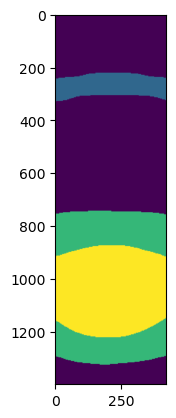

In [26]:
checkpoint_path = "runs/DeepLabV3_ResNet50_20251006_140615/checkpoints/DeepLabV3_ResNet50_epoch_20.pth"
predictor = SegPredictor(checkpoint_path, num_classes=4, crop_size=512)

img_path = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset_eye/dataset/eye_data/images/val/CN035_JP_19_M_OD_6-0D_4_Horizontal.png"

image, pred = predictor.predict(img_path)

image2 = image[:, 215:635]
pred2 = pred[:, 215:635]

plt.imshow(pred2)
# plt.imshow(image)
plt.show

In [72]:
class OpticalAnalyzer:
    def __init__(self, x_pix=7.1/1000, y_pix=9.819/1000, n_values=None):
        self.x_pix = x_pix
        self.y_pix = y_pix
        self.n_values = n_values or [1, 1.3665, 1.3266, 1.3749, 1.3947, 1.3749]

    # ---- Helper Functions ----
    def polyfit(self, x, y, deg=3):
        mask = ~np.isnan(x) & ~np.isnan(y)
        if np.sum(mask) < deg + 1:
            return np.full_like(y, np.nan, dtype=float)
        fit_value = np.polyfit(x[mask], y[mask], deg)
        model = np.poly1d(fit_value)
        y_fit = np.full_like(y, np.nan, dtype=float)
        y_fit[mask] = model(x[mask])
        return y_fit

    def extract_surface(self, mask):
        H, W = mask.shape
        anterior, posterior = np.zeros(W), np.zeros(W)
        for col in range(W):
            ys = np.where(mask[:, col] > 0)[0]
            if len(ys) > 0:
                anterior[col] = ys[1] if len(ys) > 1 else ys[0]
                posterior[col] = ys[-3] if len(ys) > 3 else ys[-1]
            else:
                anterior[col] = posterior[col] = np.nan
        x = np.arange(W)
        return x, anterior, posterior

    def compute_optical_positions(self, I_layers):
        num_layers = len(I_layers)
        if len(self.n_values) != num_layers:
            raise ValueError("Refractive index list size mismatch")
        O = [I_layers[0].copy()]
        od, gd = [], [0.0]
        for i in range(num_layers - 1):
            od_i = I_layers[i + 1] - I_layers[i]
            gd_i = od_i / self.n_values[i+1]
            od.append(od_i)
            gd.append(gd_i)
            O.append(O[-1] + gd_i)
        return {"O": O, "od": od, "gd": gd}

    def fit_circle(self, x, y):
        mask = ~np.isnan(x) & ~np.isnan(y)
        x, y = x[mask], y[mask]
        A = np.c_[2*x, 2*y, np.ones(len(x))]
        b = x**2 + y**2
        c, _, _, _ = np.linalg.lstsq(A, b, rcond=None)
        xc, yc = c[0], c[1]
        radius = np.sqrt(c[2] + xc**2 + yc**2)
        return xc, yc, radius

    # ---- Main Pipeline ----
    def raytracing(self, pred):
        pred2 = pred[:, 215:635]

        # masks
        cornea = (pred2 == 1).astype(np.uint8)
        lens = (pred2 == 2).astype(np.uint8)
        nucleus = (pred2 == 3).astype(np.uint8)

        # surfaces
        x1, y1, y2 = self.extract_surface(cornea)
        x2, y1_lens, y2_lens = self.extract_surface(lens)
        x3, y1_nuc, y2_nuc = self.extract_surface(nucleus)

        # convert to physical space
        x1p, x2p, x3p = x1*self.x_pix, x2*self.x_pix, x3*self.x_pix
        y1p, y2p = y1*self.y_pix, y2*self.y_pix
        y1_lensp, y2_lensp = y1_lens*self.y_pix, y2_lens*self.y_pix
        y1_nucp, y2_nucp = y1_nuc*self.y_pix, y2_nuc*self.y_pix

        # polynomial fits
        I1 = self.polyfit(x1p, y1p)
        I2 = self.polyfit(x1p, y2p)
        I3 = self.polyfit(x2p, y1_lensp)
        I4 = self.polyfit(x3p, y1_nucp)
        I5 = self.polyfit(x3p, y2_nucp)
        I6 = self.polyfit(x2p, y2_lensp)

        # compute optical geometry
        results = self.compute_optical_positions([I1, I2, I3, I4, I5, I6])
        O_layers, gd_layers = results["O"], results["gd"]

        # circle fitting
        radii = []
        for x, O in zip([x1p, x1p, x1p, x1p, x1p, x1p], O_layers):
            _, _, r = self.fit_circle(x, O)
            radii.append(r)

        results2 = {"radii": radii,
                    "gd": gd_layers}
        
        curves = np.vstack([
            y1,           # Cornea anterior
            y2,           # Cornea posterior
            y1_lens,      # Lens anterior
            y1_nuc,   # Nucleus anterior
            y2_nuc,   # Nucleus posterior
            y2_lens       # Lens posterior
        ])
        curves_clean = np.nan_to_num(np.round(curves), nan=-1).astype(np.float64)
        return results2, curves_clean, O_layers


In [108]:
checkpoint_path = "runs/DeepLabV3_ResNet50_20251006_140615/checkpoints/DeepLabV3_ResNet50_epoch_20.pth"
img_path = "/media/be-light/Data/PG_Gdansk/Torun_secondment/Experiments/dataset_eye/dataset/eye_data/images/val/CN035_JP_19_M_OD_6-0D_4_Horizontal.png"

predictor = SegPredictor(checkpoint_path, num_classes=4, crop_size=512)
image, pred = predictor.predict(img_path)
image2 = image[:, 215:635]
pred2 = pred[:, 215:635]

analyzer = OpticalAnalyzer()
results, curves, O = analyzer.raytracing(pred)

gd_layers =results['gd']
roc = results["radii"]
gd_mean = [np.nanmean(gd) for gd in results["gd"]]
d1 = np.sum(gd_mean[:3])
d2 = np.sum(gd_mean[3:])

data = {
    "Layer": ["GD Cornea Anterior", "GD Cornea Posterior", "GD Lense Anterior", "GD Nucleus Anterior","GD Nucleus Posterior", "GD Lens Posterior"]
                + ["D1", "D2"]+
            ["RoC Cornea Anterior", "RoC Cornea Posterior", "RoC Lense Anterior", "RoC Nucleus Anterior","RoC Nucleus Posterior", "RoC Lens Posterior"],
    # "Layer": [f"GD{i+1}" for i in range(len(gd_mean))] + ["d1", "d2"] + [f"RoC{i+1}" for i in range(len(roc))],
    "Value (mm)": [*gd_mean, d1, d2, *roc]
}
df = pd.DataFrame(data)
# df
csv_path = "optical_results.csv"
excel_path = "optical_results.xlsx"
df.to_csv(csv_path, index=False)
df.to_excel(excel_path, index=False, engine="openpyxl")
# for idx, val in enumerate(gd_mean, start=1):
#     print(f"GD{idx}: {val:.4f} mm")
# print(f"d1: {d1:.3f} mm\nd2: {d2:.3f} mm")

# for idx, r in enumerate(results["radii"], start=1):
#     print(f"RoC {idx}: {r:.3f} mm")


In [ ]:
np.savetxt("label_CN035_6-0D_4_H.csv", curves, fmt="%d", delimiter=",")